# CNN vs MLP
In this notebook it will be showed how to train a CNN and what are its advantages (and disanvantages) with respect to a fully connected network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

C:\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Dataset Loading
First step we need to load the dataset that will be used for train and test.

In this case MNIST dataset will be used. MNIST consist in black and white images of handwritten digits between 0-9.

Pytorch Dataloaders will be used for this task.

In [3]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

# TRAIN dataset
# Pytorch already has some datasets available for downlaod
train_dataset = datasets.MNIST('../data', train=True, download=True, 
                       # transforms that we want to apply when iterating the dataset
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # mean and std of MNIST dataset
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# The dataloader will iterate through the dataset and load the data in memory
train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=64, shuffle=True)

# TEST dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

In [4]:
print(len(train_dataset), len(train_loader)) #WHY?

60000 938


In [5]:
# plotting libs
from res.plot_lib import plot_data, plot_model, set_default
set_default()

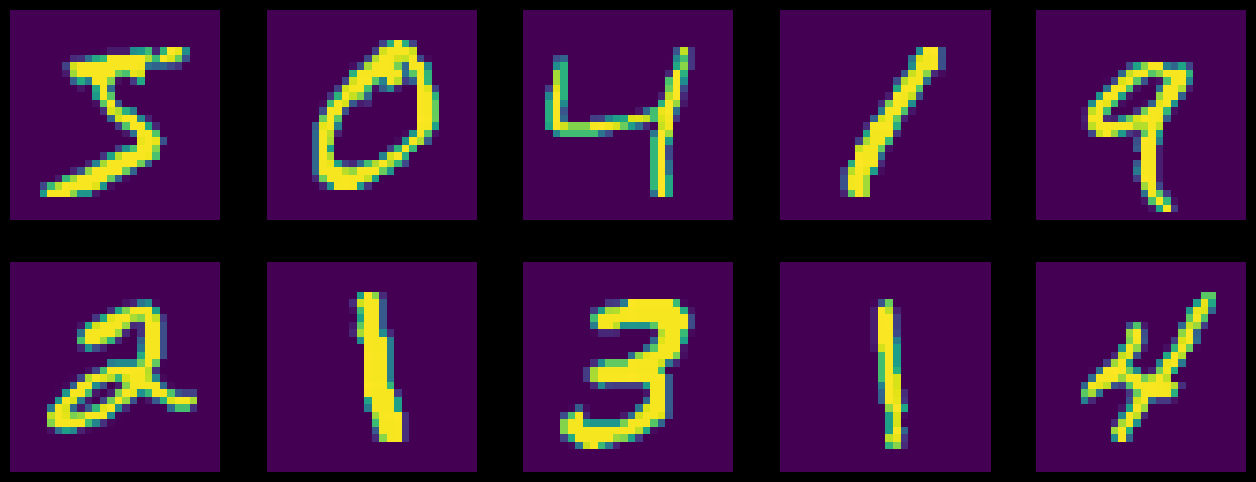

In [6]:
# show some images
def denorm_mnist(x):
    m = 0.1307
    std = 0.3081
    # denormalization operation = std*x + m
    return x*std + m

to_pil = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i) # load one image
    plt.imshow(to_pil(denorm_mnist(image)))
    plt.axis('off')

## Network Definition
Let's define and MLP and a CNN to solve the MNIST digit classification task.

In [7]:
# MLP
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten
        return self.network(x)

# CNN
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv_block1(x) # what is the output size?
        x = self.conv_block2(x) # what is the output size?
        x = x.view(-1, self.n_feature*4*4) # flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [8]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# define train and test function
accuracy_list = []
def train(epoch, model, optimizer, perm=None): #perm = torch.arange(0, 784).long()
    model.train()
    # dataloader will iterate the dataset and return images (data)
    # and labels (target)
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=None): #perm = torch.arange(0, 784).long()
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [10]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314888
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.641381
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.018839
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.988682
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.686173
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.664654
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.379700
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.457586
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.466364
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.539479

Test set: Average loss: 0.4658, Accuracy: 8609/10000 (86%)



In [11]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307522
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.186299
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.744275
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.411148
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.226652
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.369818
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.199165
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.164997
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.283757
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.244135

Test set: Average loss: 0.1598, Accuracy: 9517/10000 (95%)



The CNN performs much better that an MLP on images.

Now let's try to shuffle the pixels!

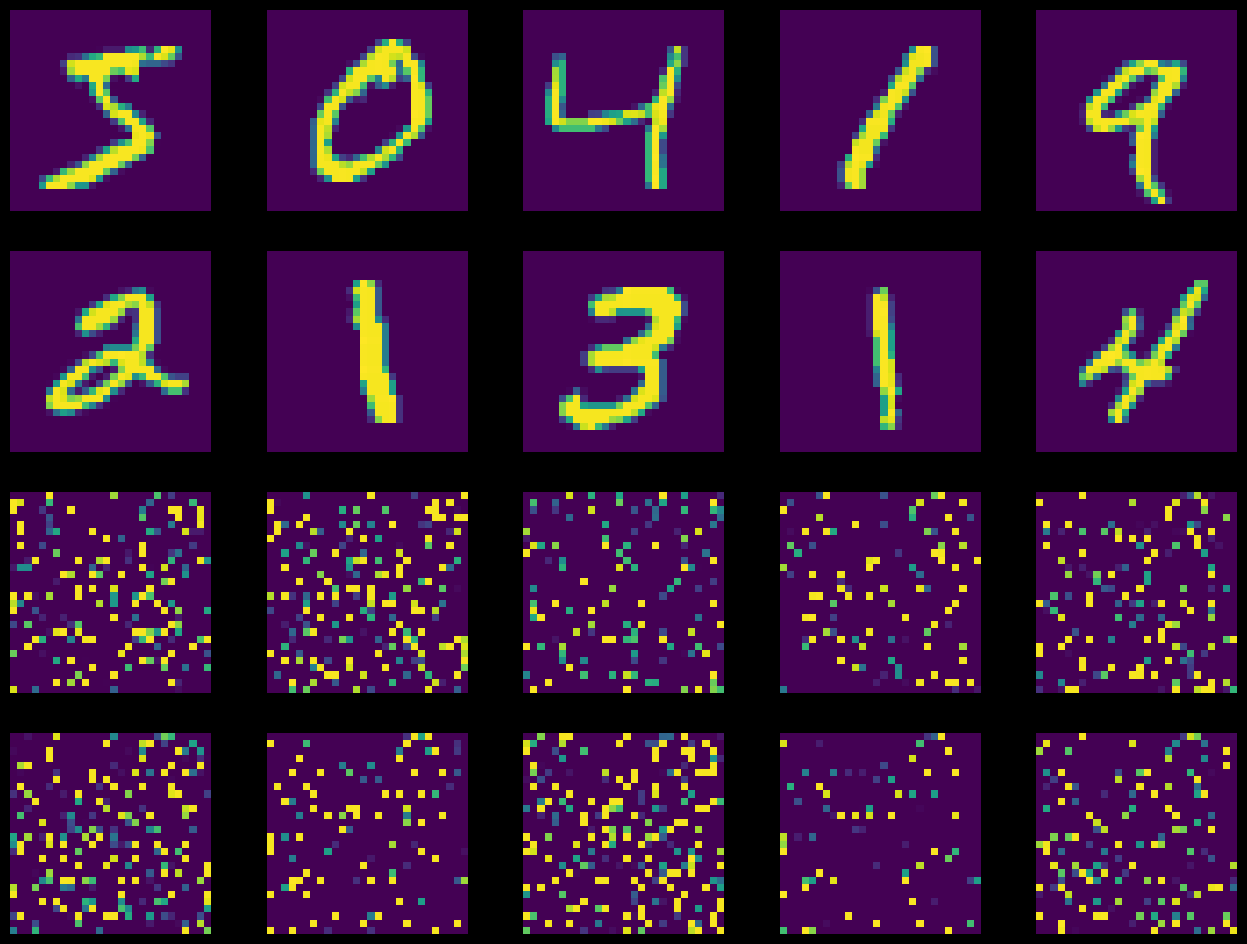

In [12]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(to_pil(denorm_mnist(image.squeeze())))
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(to_pil(denorm_mnist(image_perm.squeeze())))
    plt.axis('off')

### How the CNN will perform now?

In [13]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316327
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.292959
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.225667
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.860777
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.603143
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.160402
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.954365
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.034604
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.835393
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.869028

Test set: Average loss: 0.6339, Accuracy: 8047/10000 (80%)



### How about the MLP?

In [14]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.327039
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.726713
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.187916
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.789417
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.768184
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.716975
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.457357
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.431421
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.449836
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.354490

Test set: Average loss: 0.4259, Accuracy: 8680/10000 (87%)



### The CNN performances dropped!!!
WHY? The concept of locality was lost: pixel are no longer stationary on a grid

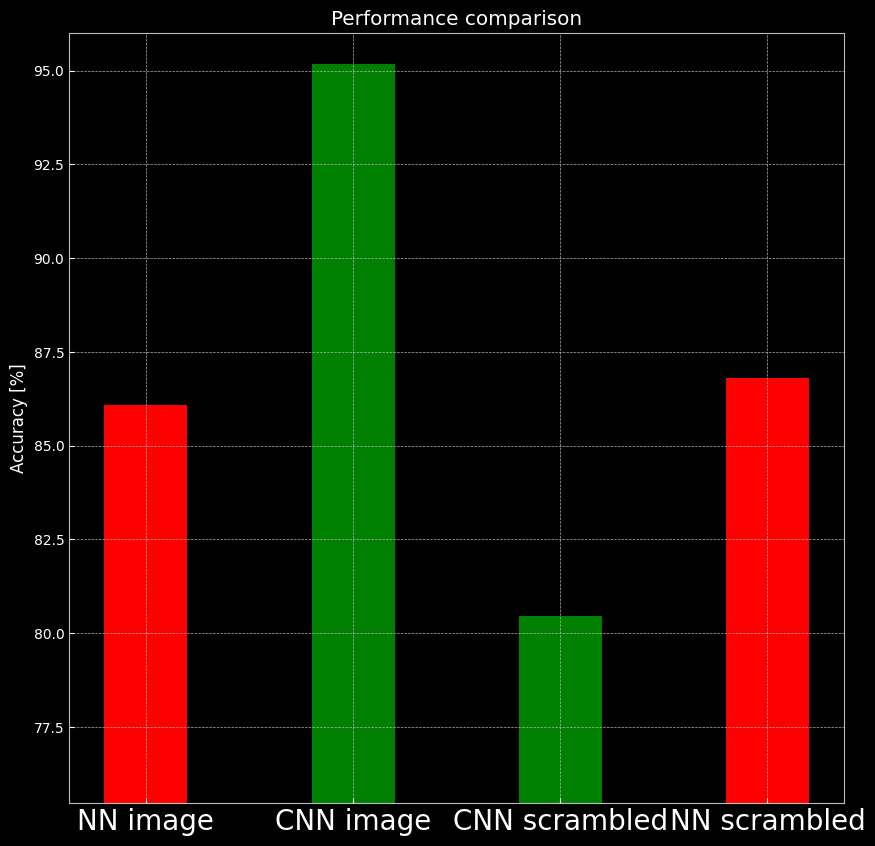

In [15]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4, color = ['red', 'green', 'green', 'red'])
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');